## Step 3: Optimization with uncertain conversion rates

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from Environment.E_commerce import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.TS_Learner import *
from Algorithms.UCB_Learner import *

In [2]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],np.multiply([0.5, 0.5, 0.5, 0.5],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes


products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = E_commerce()
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])
E.set_products(products)
E.set_lambda(0.5)

In [14]:
#Random algorithm which for each round pulls a random choice 
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
# useful for computing clairvoyant solution and regrets of the bandit algorithms


n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i] 
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms

_______________________________________________
Conversion rates
[[0.97365913 0.75679633 0.26181428 0.00621794]
 [0.97708611 0.76770829 0.16526625 0.00405438]
 [0.99197225 0.8206721  0.20134713 0.00893346]
 [0.9940605  0.71451176 0.25768576 0.03125852]
 [0.99604795 0.90093095 0.12099998 0.00411991]]
_______________________________________________
Expected rewards per arm
[[ 7.80510878  9.05733489  4.16035671  0.06538967]
 [ 5.87866503  6.5881263   1.95909173  0.01598376]
 [23.29648111 26.74488479  8.2315493   0.29320647]
 [46.65907932 44.11910983 18.34341263  2.32912638]
 [39.995      45.20332513  7.08200801  0.        ]]
_______________________________________________
Expected units sold per arm
[[2.  2.  2.  1.4]
 [1.  1.  1.  0.4]
 [3.  3.  3.  2.7]
 [3.  3.  3.  3. ]
 [1.  1.  1.  0. ]]
_______________________________________________
Best configuration [1. 1. 1. 0. 1.]
Optimal cumulative expected reward per round
133.8138202001112


In [26]:
#Comparison between TS and UCB

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 10

ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []
gr_rewards_per_experiment = []
cr_rewards_per_experiment = []

ts_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    gr_learner = Greedy(n_arms=n_arms)
    ucb_learner = UCB(n_arms=n_arms)
    ts_learner = TS(n_arms=n_arms)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)

        pulled_arm = gr_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        gr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)  

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)
    gr_rewards_per_experiment.append(gr_learner.collected_rewards)
    cr_rewards_per_experiment.append(cr_learner.collected_rewards)

    ts_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)


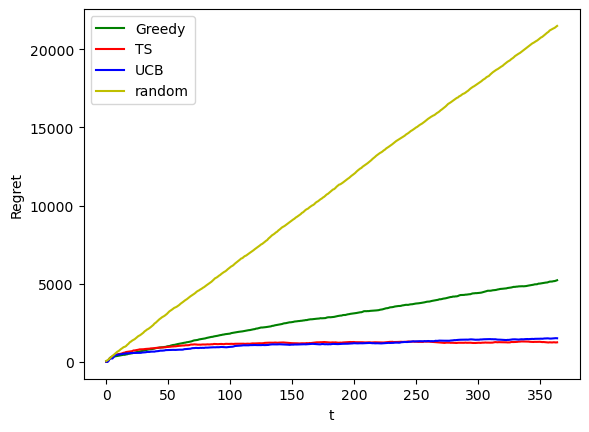

In [27]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g')
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.plot(np.cumsum(np.mean(opt - cr_rewards_per_experiment, axis=0)), 'y')
plt.legend(["Greedy","TS","UCB","random"])
plt.show()

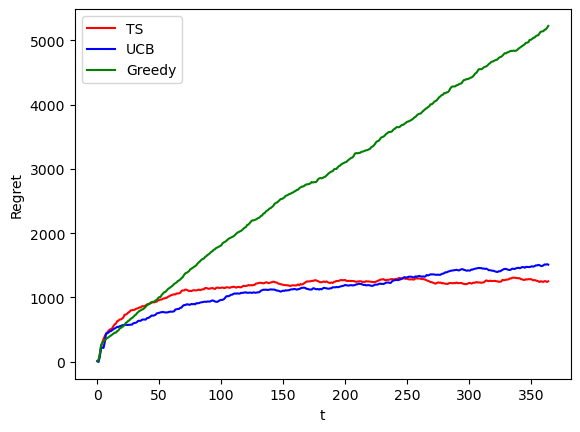

In [28]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g')
plt.legend(["TS","UCB", "Greedy"])
plt.show()

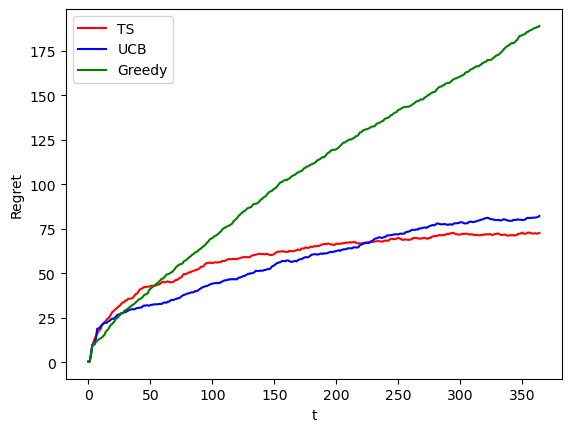

In [10]:
#Standardized
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)/np.std(opt - ts_rewards_per_experiment)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)/np.std(opt - ucb_rewards_per_experiment)), 'b')
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)/np.std(opt - gr_rewards_per_experiment)), 'g')
plt.legend(["TS","UCB", "Greedy"])
plt.show()

In [45]:
print("_______________________________________________")
print("TS Total collected reward")
print(np.sum(np.mean(ts_rewards_per_experiment,axis=0)))
print("UCB Total collected reward")
print(np.sum(np.mean(ucb_rewards_per_experiment,axis=0)))
print("_______________________________________________")

print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(ts_rewards_per_experiment, axis=1)),np.std(np.sum(ts_rewards_per_experiment, axis = 1)))
print("UCB",np.mean(np.sum(ucb_rewards_per_experiment, axis=1)),np.std(np.sum(ucb_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(opt - ts_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ts_rewards_per_experiment, axis=1)))
print("UCB",np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ucb_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(ts_rewards_per_experiment, axis=0)), np.std(np.mean(ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(ucb_rewards_per_experiment, axis=0)), np.std(np.mean(ucb_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(opt-ts_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(opt-ucb_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ucb_rewards_per_experiment, axis=0)))

_______________________________________________
TS Total collected reward
47082.330035833336
UCB Total collected reward
47232.318985833335
_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 365 days and its standard deviation considering 20 experiments
TS 47082.330035833336 497.9454936746116
UCB 47232.318985833335 577.1435934005442
-----------------------------------------------
Total expected regret over 365 days and its standard deviation considering 20 experiments
TS 1693.1735500018463 497.9454936746126
UCB 1543.1846000018463 577.1435934005445
-----------------------------------------------
Average expected reward per round over 365 days and its standard deviation between the rounds considering 20 experiments
TS 128.99268502968036 11.532850342077037
UCB 129.40361365981735 12.154076280022487
-----------------------------------------------
Average expected regret per round over 365

In [46]:
print("TS Pulls per arm")
for i in range(len(ts_pulls_per_arm_per_experiment)):
    print("_______________________________________________")
    print(ts_pulls_per_arm_per_experiment[i])

TS Pulls per arm
_______________________________________________
[[  1. 348.   9.   7.]
 [182. 166.  11.   6.]
 [  2. 352.   7.   4.]
 [303.  45.  10.   7.]
 [ 51. 306.   4.   4.]]
_______________________________________________
[[  6. 341.   8.  10.]
 [ 10. 343.   6.   6.]
 [  2. 348.   8.   7.]
 [308.  38.  16.   3.]
 [ 60. 295.   4.   6.]]
_______________________________________________
[[ 12. 337.   8.   8.]
 [ 63. 289.   6.   7.]
 [ 13. 342.   4.   6.]
 [281.  64.  16.   4.]
 [  1. 352.   6.   6.]]
_______________________________________________
[[ 11. 335.  12.   7.]
 [ 31. 318.   9.   7.]
 [  1. 353.   5.   6.]
 [202. 153.   6.   4.]
 [  2. 353.   5.   5.]]
_______________________________________________
[[ 31. 318.  10.   6.]
 [ 16. 334.   8.   7.]
 [ 41. 312.   4.   8.]
 [324.  28.  10.   3.]
 [ 78. 273.   9.   5.]]
_______________________________________________
[[ 23. 323.  12.   7.]
 [  1. 353.   3.   8.]
 [ 20. 333.   5.   7.]
 [319.  35.   4.   7.]
 [  8. 348.   5.   4.]]

In [47]:
print("UCB Pulls per arm")
for i in range(len(ucb_pulls_per_arm_per_experiment)):
    print("_______________________________________________")
    print(ucb_pulls_per_arm_per_experiment[i])

UCB Pulls per arm
_______________________________________________
[[ 29. 332.   2.   2.]
 [ 75. 286.   2.   2.]
 [118. 241.   4.   2.]
 [279.  77.   5.   4.]
 [ 43. 315.   5.   2.]]
_______________________________________________
[[ 94. 259.  10.   2.]
 [105. 251.   5.   4.]
 [ 32. 327.   4.   2.]
 [313.  46.   4.   2.]
 [ 62. 299.   2.   2.]]
_______________________________________________
[[ 68. 277.  18.   2.]
 [ 68. 286.   7.   4.]
 [ 66. 293.   2.   4.]
 [244. 107.  12.   2.]
 [ 73. 288.   2.   2.]]
_______________________________________________
[[ 40. 318.   5.   2.]
 [120. 241.   2.   2.]
 [ 49. 305.   9.   2.]
 [307.  54.   2.   2.]
 [ 91. 270.   2.   2.]]
_______________________________________________
[[ 59. 300.   4.   2.]
 [123. 234.   6.   2.]
 [ 72. 280.   9.   4.]
 [216. 142.   2.   5.]
 [354.   2.   7.   2.]]
_______________________________________________
[[ 57. 299.   5.   4.]
 [ 52. 306.   5.   2.]
 [349.   2.  12.   2.]
 [191. 163.   7.   4.]
 [ 63. 298.   2.   2.]

In [51]:
#Comparison between TS and UCB with respect to the number of users per round

n_arms = 4
num_users = 10
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 30

ts_rewards_per_experiment_10 = []
ucb_rewards_per_experiment_10 = []

ts_rewards_per_experiment_100 = []
ucb_rewards_per_experiment_100 = []


ts_rewards_per_experiment_1000 = []
ucb_rewards_per_experiment_1000 = []


for e in range(n_experiments):

    env_10 = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_10 = UCB(n_arms=n_arms)
    ts_learner_10 = TS(n_arms=n_arms)

    env_100 = Environment(n_arms, E, margins_matrix, num_users*10, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_100 = UCB(n_arms=n_arms)
    ts_learner_100 = TS(n_arms=n_arms)

    env_1000 = Environment(n_arms, E, margins_matrix, num_users*100, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_1000 = UCB(n_arms=n_arms)
    ts_learner_1000 = TS(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ucb_learner_10.pull_arm()
        reward = env_10.round(pulled_arm)
        ucb_learner_10.update(pulled_arm, reward)

        pulled_arm = ucb_learner_100.pull_arm()
        reward = env_100.round(pulled_arm)
        ucb_learner_100.update(pulled_arm, reward)

        pulled_arm = ucb_learner_1000.pull_arm()
        reward = env_1000.round(pulled_arm)
        ucb_learner_1000.update(pulled_arm, reward)
        
        pulled_arm = ts_learner_10.pull_arm(env_10.margins_matrix)
        reward = env_10.round(pulled_arm)
        ts_learner_10.update(pulled_arm, reward, env_10.clicks_current_day, env_10.purchases_current_day, env_10.daily_units)

        pulled_arm = ts_learner_100.pull_arm(env_100.margins_matrix)
        reward = env_100.round(pulled_arm)
        ts_learner_100.update(pulled_arm, reward, env_100.clicks_current_day, env_100.purchases_current_day,  env_100.daily_units)

        pulled_arm = ts_learner_1000.pull_arm(env_1000.margins_matrix)
        reward = env_1000.round(pulled_arm)
        ts_learner_1000.update(pulled_arm, reward, env_1000.clicks_current_day, env_1000.purchases_current_day,  env_1000.daily_units)

    ts_rewards_per_experiment_10.append(ts_learner_10.collected_rewards)
    ucb_rewards_per_experiment_10.append(ucb_learner_10.collected_rewards)

    
    ts_rewards_per_experiment_100.append(ts_learner_100.collected_rewards)
    ucb_rewards_per_experiment_100.append(ucb_learner_100.collected_rewards)

    
    ts_rewards_per_experiment_1000.append(ts_learner_1000.collected_rewards)
    ucb_rewards_per_experiment_1000.append(ucb_learner_1000.collected_rewards)


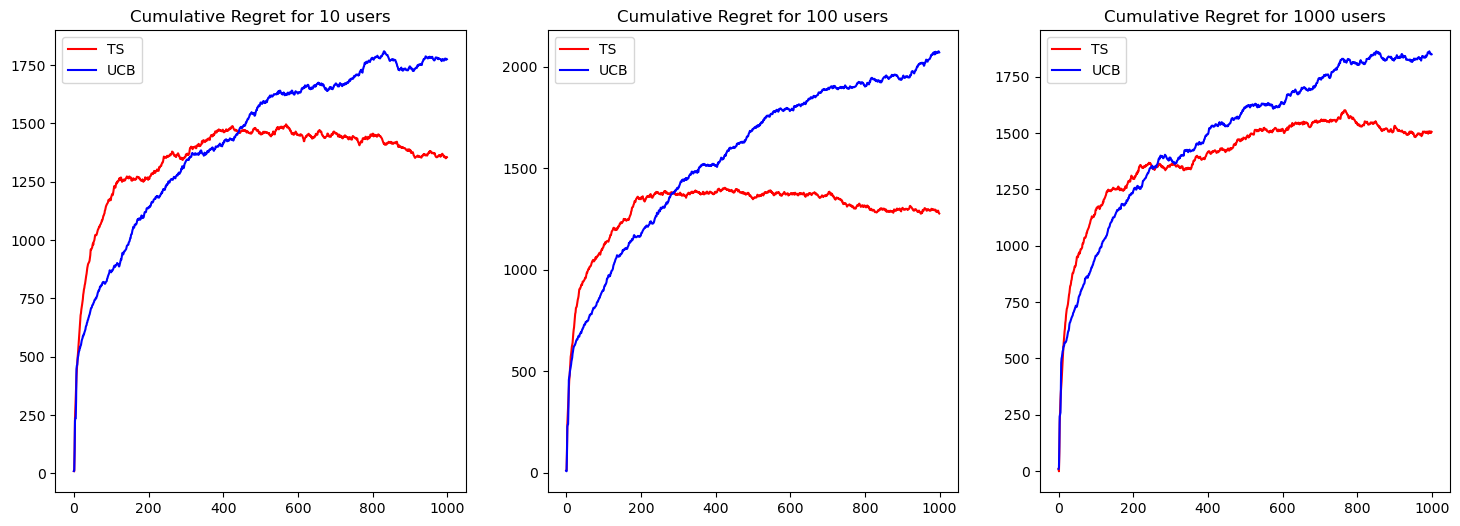

In [52]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,6))
ax[0].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_10, axis=0)), 'r')
ax[0].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_10, axis=0)), 'b')
ax[0].set_title("Cumulative Regret for 10 users")
ax[0].legend(["TS","UCB"])

ax[1].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_100, axis=0)), 'r')
ax[1].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_100, axis=0)), 'b')
ax[1].set_title("Cumulative Regret for 100 users")
ax[1].legend(["TS","UCB"])

ax[2].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_1000, axis=0)), 'r')
ax[2].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_1000, axis=0)), 'b')
ax[2].set_title("Cumulative Regret for 1000 users")
ax[2].legend(["TS","UCB"])

plt.show()